# Focal Plane calibration reproducibility

Stephen Bailey, December 2019

Using calibrations of Petal Location 7 from /data/focalplane/logs/calib_logs/ run on Nov 25 and Dec 1.

In [15]:
%pylab inline
import numpy as np
from astropy.table import Table
from astropy.stats import sigma_clipped_stats

Populating the interactive namespace from numpy and matplotlib


In [88]:
#- Read both calibrations and trim to just positioners that are in both
file1 = '20191125T135345-0700-arc_calibration.csv'
file2 = '20191201T195504-0700-arc_calibration.csv'

t1 = Table.read(file1)
t2 = Table.read(file2)

print('{}: {} positioners'.format(file1, len(t1)))
print('{}: {} positioners'.format(file2, len(t2)))

t1 = t1[np.in1d(t1['DEVICE_ID'], t2['DEVICE_ID'])]
t2 = t2[np.in1d(t2['DEVICE_ID'], t1['DEVICE_ID'])]
print('Studying {} positioners in both calibrations'.format(len(t1)))

t1.sort('DEVICE_LOC')
t2.sort('DEVICE_LOC')
assert np.all(t1['DEVICE_LOC'] == t2['DEVICE_LOC'])
assert np.all(t1['DEVICE_ID'] == t2['DEVICE_ID'])

20191125T135345-0700-arc_calibration.csv: 493 positioners
20191201T195504-0700-arc_calibration.csv: 460 positioners
Studying 460 positioners in both calibrations


In [89]:
#- Load design x,y
import desimodel.io
petal_loc = t1['PETAL_LOC'][0]
fp = desimodel.io.load_deviceloc()
fp = fp[fp['PETAL'] == petal_loc]
fp = fp[np.in1d(fp['DEVICE'], t1['DEVICE_LOC'])]
fp.sort('DEVICE')
assert np.all(fp['DEVICE'] == t2['DEVICE_LOC'])

#- convert to petal local curved coordinates OFFSET_X, OFFSET_Y
theta = np.radians(36*(3-petal_loc))
x = fp['X'] * np.cos(theta) - fp['Y']*np.sin(theta)
y = fp['X'] * np.sin(theta) + fp['Y']*np.cos(theta)

fp['X'] = x
fp['Y'] = x
fp['Q'] += np.degrees(theta)

fp['OFFSET_X'] = fp['S']*np.cos(np.radians(fp['Q']))
fp['OFFSET_Y'] = fp['S']*np.sin(np.radians(fp['Q']))

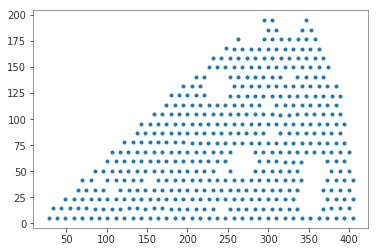

In [90]:
plot(fp['OFFSET_X'], fp['OFFSET_Y'], '.')

In [91]:
fp.colnames

['PETAL',
 'DEVICE',
 'DEVICE_TYPE',
 'LOCATION',
 'FIBER',
 'X',
 'Y',
 'Z',
 'Q',
 'S',
 'SPECTRO',
 'SLIT',
 'SLITBLOCK',
 'BLOCKFIBER',
 'OFFSET_X',
 'OFFSET_Y']

## Arm lengths are correlated between the two calibration runs

With some outliers, and curiously some extreme outliers that get the same answer in both calibrations

In [113]:
dr1 = 1000*(t2['LENGTH_R1'] - t1['LENGTH_R1'])
mean_dr1, median_dr1, sigma_dr1 = sigma_clipped_stats(dr1)
num_outliers_dr1 = np.count_nonzero(np.abs(dr1) > 5*sigma_dr1)
print('Delta_r1: mean {:.1f} +- {:.1f} microns, std {:.1f} microns'.format(mean_dr1, sigma_dr1/np.sqrt(len(t2)), sigma_dr1))
print('          {} outliers (5-sigma)'.format(num_outliers_dr1))

dr2 = 1000*(t2['LENGTH_R2'] - t1['LENGTH_R2'])
mean_dr2, median_dr2, sigma_dr2 = sigma_clipped_stats(dr2)
num_outliers_dr2 = np.count_nonzero(np.abs(dr2) > 5*sigma_dr2)
print('Delta_r2: mean {:.1f} +- {:.1f} microns, std {:.1f} microns'.format(mean_dr2, sigma_dr2/np.sqrt(len(t2)), sigma_dr2))
print('          {} outliers (5-sigma)'.format(num_outliers_dr2))

Delta_r1: mean -7.5 +- 1.4 microns, std 29.6 microns
          12 outliers (5-sigma)
Delta_r2: mean -10.1 +- 1.6 microns, std 34.6 microns
          8 outliers (5-sigma)


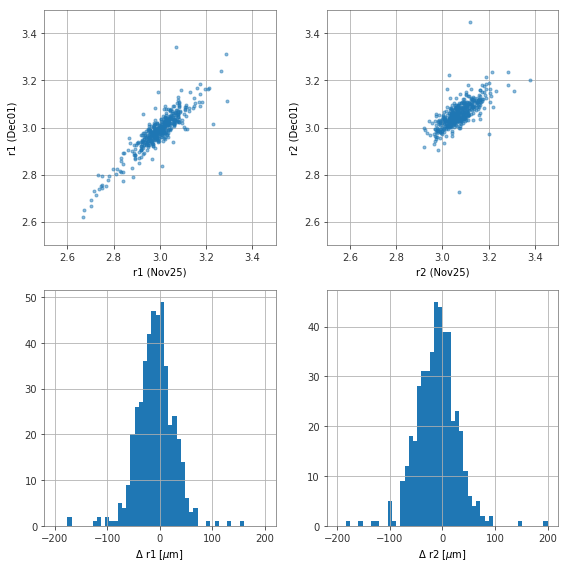

In [141]:
figure(figsize=(8,8))
subplot(221)
plot(t1['LENGTH_R1'], t2['LENGTH_R1'], '.', alpha=0.5)
xlabel('r1 (Nov25)'); ylabel('r1 (Dec01)')
xlim(2.5,3.5); ylim(2.5, 3.5)
grid()

subplot(223)
hist(dr1, 50, (-200, 200))
xlabel('$\Delta$ r1 [$\mu$m]')
grid()

subplot(222)
plot(t1['LENGTH_R2'], t2['LENGTH_R2'], '.', alpha=0.5)
xlabel('r2 (Nov25)'); ylabel('r2 (Dec01)')
xlim(2.5,3.5); ylim(2.5, 3.5)
grid()

subplot(224)
dr2 = 1000*(t2['LENGTH_R2'] - t1['LENGTH_R2'])
hist(dr2, 50, (-200, 200))
xlabel('$\Delta$ r2 [$\mu$m]')
grid()

tight_layout()

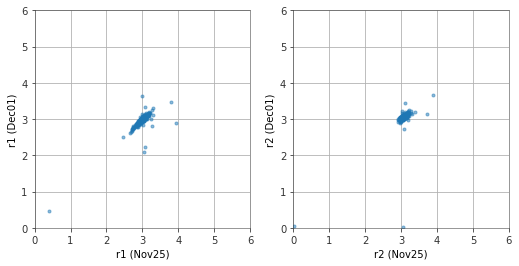

In [92]:
figure(figsize=(8.5,4))
subplot(121)
plot(t1['LENGTH_R1'], t2['LENGTH_R1'], '.', alpha=0.5)
xlabel('r1 (Nov25)'); ylabel('r1 (Dec01)')
xlim(0,6); ylim(0,6)
grid()

subplot(122)
plot(t1['LENGTH_R2'], t2['LENGTH_R2'], '.', alpha=0.5)
xlabel('r2 (Nov25)'); ylabel('r2 (Dec01)')
xlim(0,6); ylim(0,6)
grid()


In [120]:
#- Reproducible length outlier
ii = (t1['LENGTH_R1'] < 1) & (t2['LENGTH_R1'] < 1)
t1['DEVICE_ID', 'DEVICE_LOC', 'LENGTH_R1', 'LENGTH_R2', 'OFFSET_T', 'OFFSET_P'][ii]

DEVICE_ID,DEVICE_LOC,LENGTH_R1,LENGTH_R2,OFFSET_T,OFFSET_P
str6,int64,float64,float64,float64,float64
M01865,396,0.3981322081320063,0.011184076461412286,-2.0261751561489376,130.5563040960708


In [142]:
ii = (t1['LENGTH_R2'] > 3.5) & (t2['LENGTH_R2'] > 3.5)
t1['DEVICE_ID', 'DEVICE_LOC', 'LENGTH_R1', 'LENGTH_R2', 'OFFSET_T', 'OFFSET_P'][ii]

DEVICE_ID,DEVICE_LOC,LENGTH_R1,LENGTH_R2,OFFSET_T,OFFSET_P
str6,int64,float64,float64,float64,float64
M03945,317,3.786915153115979,3.899296428116351,-98.80685568618568,44.12423656981611


### Correlated patterns in measured arm lengths

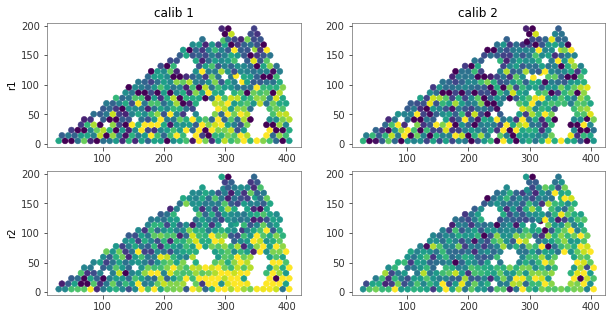

In [218]:
figure(figsize=(10,5))

subplot(221)
scatter(t1['OFFSET_X'], t1['OFFSET_Y'], c=t1['LENGTH_R1'].clip(2.9, 3.1))
ylabel('r1')
title('calib 1')
subplot(223)
scatter(t1['OFFSET_X'], t1['OFFSET_Y'], c=t1['LENGTH_R2'].clip(2.95, 3.15))
ylabel('r2')

subplot(222)
scatter(t2['OFFSET_X'], t2['OFFSET_Y'], c=t2['LENGTH_R1'].clip(2.9, 3.1))
title('calib 2')
subplot(224)
scatter(t2['OFFSET_X'], t2['OFFSET_Y'], c=t2['LENGTH_R2'].clip(2.95, 3.15))


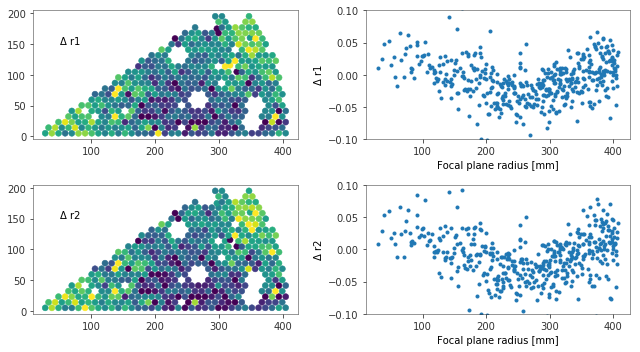

In [239]:
fpr = np.sqrt(t1['OFFSET_X']**2 + t1['OFFSET_Y']**2)

figure(figsize=(9,5))
subplot(221)
scatter(t1['OFFSET_X'], t1['OFFSET_Y'], c=(t2['LENGTH_R1'] - t1['LENGTH_R1']).clip(-0.07, 0.07))
text(50, 150, '$\Delta$ r1')

subplot(222)
plot(fpr, t2['LENGTH_R1'] - t1['LENGTH_R1'], '.')
ylim(-0.1, 0.1)
ylabel('$\Delta$ r1')
xlabel('Focal plane radius [mm]')

subplot(223)
scatter(t1['OFFSET_X'], t1['OFFSET_Y'], c=(t2['LENGTH_R2'] - t1['LENGTH_R2']).clip(-0.07, 0.07))
text(50, 150, '$\Delta$ r2')

subplot(224)
plot(fpr, t2['LENGTH_R2'] - t1['LENGTH_R2'], '.')
ylim(-0.1, 0.1)
ylabel('$\Delta$ r2')
xlabel('Focal plane radius [mm]')

tight_layout()


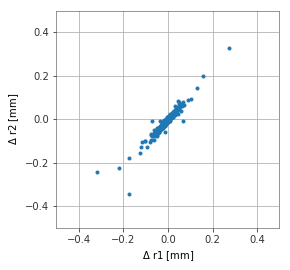

In [243]:
dr1 = t2['LENGTH_R1'] - t1['LENGTH_R1']
dr2 = t2['LENGTH_R2'] - t1['LENGTH_R2']

figure(figsize=(4,4))
plot(dr1, dr2, '.')
xlabel('$\Delta$ r1 [mm]')
ylabel('$\Delta$ r2 [mm]')
xlim(-0.5, 0.5)
ylim(-0.5, 0.5)
grid()

# OFFSET_X,Y

Text(0.5,0,'calib2 - design')

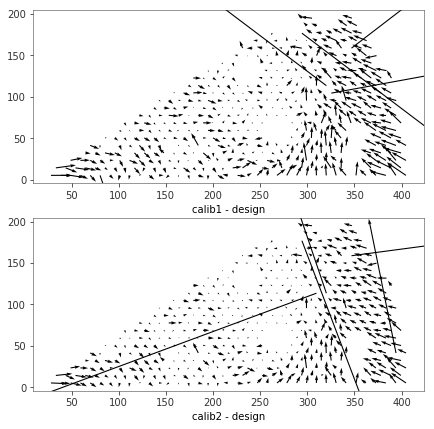

In [149]:
x = fp['OFFSET_X']
y = fp['OFFSET_Y']
dx1 = t1['OFFSET_X'] - fp['OFFSET_X']
dx2 = t2['OFFSET_X'] - fp['OFFSET_X']
dy1 = t1['OFFSET_Y'] - fp['OFFSET_Y']
dy2 = t2['OFFSET_Y'] - fp['OFFSET_Y']
dxy1 = np.sqrt(dx1**2 + dy1**2)
dxy2 = np.sqrt(dx2**2 + dy2**2)

figure(figsize=(7,7))
subplot(211)
quiver(x, y, dx1, dy1)
xlabel('calib1 - design')

subplot(212)
quiver(x, y, dx2, dy2)
xlabel('calib2 - design')

In [150]:
sigma_clipped_stats(dxy1)

(0.05107016504559151, 0.0457879074820865, 0.03037687275535254)

(0.006235747576319563, 12)

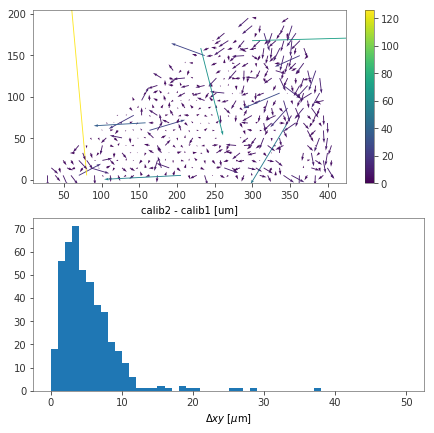

In [190]:
dxx = np.array(t2['OFFSET_X'] - t1['OFFSET_X'])
dyy = np.array(t2['OFFSET_Y'] - t1['OFFSET_Y'])
ii = (np.abs(dxx)<0.2) & (np.abs(dyy)<0.2)
drr = np.sqrt(dxx**2 + dyy**2)

figure(figsize=(7,7))
subplot(211)
quiver(x[ii], y[ii], 1000*dxx[ii], 1000*dyy[ii], 1000*drr[ii])
colorbar()
xlabel('calib2 - calib1 [um]')

subplot(212)
hist(drr*1000, 50, (0, 50))
xlabel('$\Delta xy$ [$\mu$m]')

cutoff = 0.1
for i in range(5):
    keep = drr < cutoff
    rms_drr = np.sqrt(np.mean(drr[keep]**2))
    cutoff = 5*rms_drr

num_outliers_drr = np.count_nonzero(drr > 5*rms_drr)
rms_drr, num_outliers_drr

Text(0.5,0,'$\\Delta xy$ [$\\mu$m]')

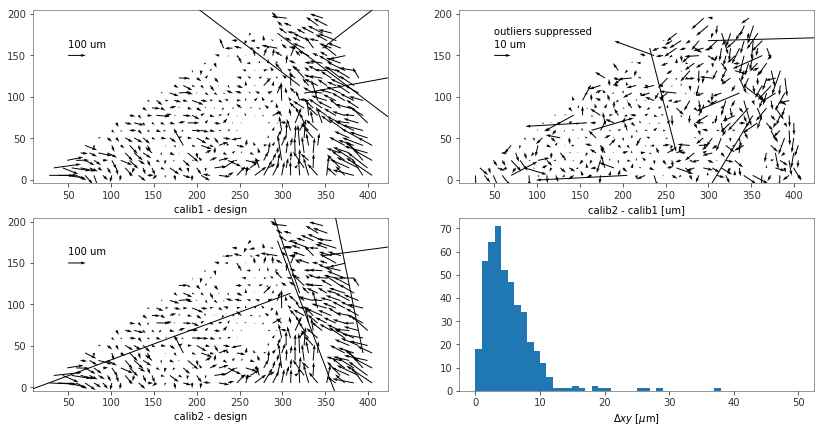

In [220]:
dxx = np.array(t2['OFFSET_X'] - t1['OFFSET_X'])
dyy = np.array(t2['OFFSET_Y'] - t1['OFFSET_Y'])
drr = np.sqrt(dxx**2 + dyy**2)

tmpx = np.concatenate([x, [50,]])
tmpy = np.concatenate([y, [150,]])
tmpdx1 = np.concatenate([dx1, [0.1,]])
tmpdy1 = np.concatenate([dy1, [0.0,]])
tmpdx2 = np.concatenate([dx2, [0.1,]])
tmpdy2 = np.concatenate([dy2, [0.0,]])

tmpdxx = np.concatenate([dxx, [0.010,]])
tmpdyy = np.concatenate([dyy, [0.0,]])

figure(figsize=(14,7))
subplot(221)
quiver(tmpx, tmpy, tmpdx1, tmpdy1, scale=2.0)
text(50, 160, '100 um')
xlabel('calib1 - design')

subplot(223)
quiver(tmpx, tmpy, tmpdx2, tmpdy2, scale=2.0)
text(50, 160, '100 um')
xlabel('calib2 - design')

subplot(222)
ok = (np.abs(tmpdxx) <= 0.1) & (np.abs(tmpdyy) <= 0.1)
quiver(tmpx[ok], tmpy[ok], tmpdxx[ok], tmpdyy[ok])
# quiver(tmpx, tmpy, tmpdxx, tmpdyy)
text(50, 160, '10 um')
text(50, 175, 'outliers suppressed')
xlabel('calib2 - calib1 [um]')

subplot(224)
hist(1000*drr, 50, (0, 50))
xlabel('$\Delta xy$ [$\mu$m]')

Calibrations agree with each other to ~10x better than they agree with design (good)

Text(0,0.5,'Calibration difference')

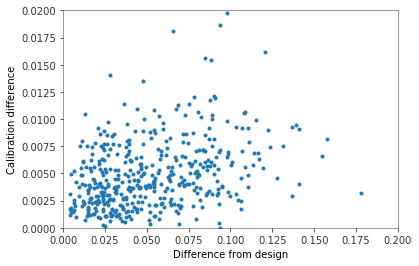

In [136]:
plot(dxy1, drr, '.')
xlim(0, 0.2)
ylim(0, 0.02)
xlabel('Difference from design')
ylabel('Calibration difference')

## Outliers

In [137]:
bad = (np.abs(dr1) > 5*sigma_dr1)
bad |= (np.abs(dr2) > 5*sigma_dr2)
bad |= (np.abs(drr) > 5*rms_drr)
np.count_nonzero(bad)

18

In [144]:
bad = (np.abs(dr1) > 100)
bad |= (np.abs(dr2) > 100)
bad |= (np.abs(drr) > 0.1)
np.count_nonzero(bad)

23